In [64]:
import pandas as pd
import numpy as np
import seaborn as sns

In [65]:
df = pd.read_csv('../data/processed_data/scopus_data_doi_cleaned_with_projections.csv')
df.head(3)

,title,abstract,year,coverdate,publication_name,citation_count,subject_areas,author_names,affiliations,countries,file_name,doi,orig_text,text,x,y
0,Artificial neural network prediction of transp...,Novel N-methyl-4-piperidinol (MPDL)-based solv...,2022,2022-08-01,Energy Reports,4.0,Energy (all),Nimmanterdwong P.+Janthboon P.+Tontiwachwuthik...,Chulalongkorn University+Clean Energy Technolo...,Thailand+Canada+China,202201532.json,10.1016/j.egyr.2022.02.117,Artificial neural network prediction of transp...,artificial neural network prediction transport...,49.010216,-38.129470
1,Light-assisted synthesis of Au/TiO2 nanopartic...,A series of Au/TiO2 photocatalysts was synthes...,2022,2022-07-01,International Journal of Hydrogen Energy,20.0,"Renewable Energy, Sustainability and the Envir...",Kunthakudee N.+Puangpetch T.+Ramakul P.+Seriva...,Chulalongkorn University+Silpakorn University+...,Thailand,202201728.json,10.1016/j.ijhydene.2022.05.150,Light-assisted synthesis of Au/TiO2 nanopartic...,light assisted synthesis au tio2 nanoparticles...,71.834885,-29.072338
2,Competition and epibiosis by the sponge Pseudo...,Competition for space on coral reefs is fierce...,2022,2022-01-01,Regional Studies in Marine Science,3.0,"Ecology, Evolution, Behavior and Systematics+A...",Allchurch A.+Mehrotra R.+Carmody H.+Monchanin ...,The University of Western Australia+Chulalongk...,Australia+Thailand+Canada+United States+France,202204089.json,10.1016/j.rsma.2021.102131,Competition and epibiosis by the sponge Pseudo...,competition epibiosis sponge pseudoceratina pu...,50.856255,68.591140


<Axes: xlabel='x', ylabel='y'>

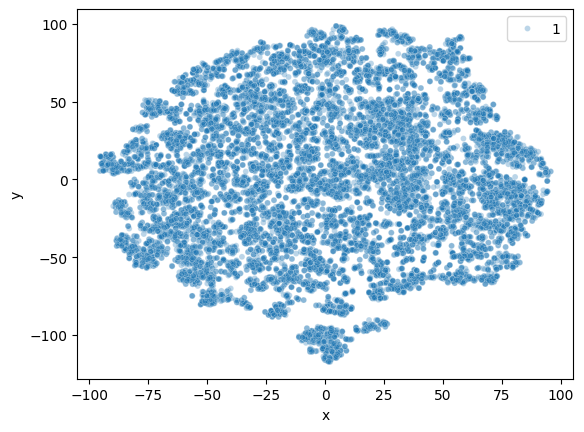

In [66]:
sns.scatterplot(data=df, x='x', y='y', alpha=0.3, size=1)

In [67]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler

#Scale x, y coordinates
scaler = StandardScaler()
df[['x', 'y']] = scaler.fit_transform(df[['x', 'y']])

#Elbow method to find optimal number of clusters
inertia = []
meandistortions = []
K = range(1, 200, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df[['x', 'y']])
    inertia.append(kmeans.inertia_)
    meandistortions.append(sum(np.min(cdist(df[['x', 'y']], kmeans.cluster_centers_, 'euclidean'), axis=1)) / df[['x', 'y']].shape[0])



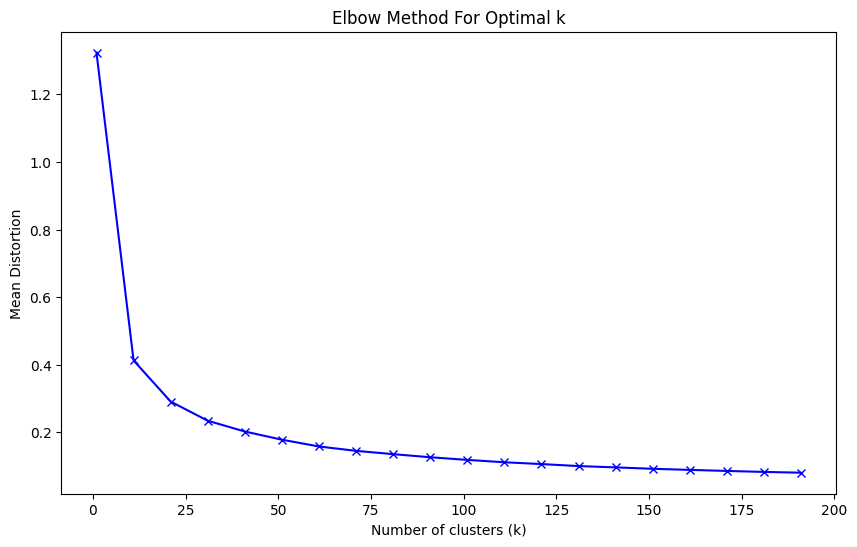

In [68]:
#Plotting the elbow curve
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(K, meandistortions, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Mean Distortion')
plt.title('Elbow Method For Optimal k')
plt.show()

In [69]:
best_clusters = 20

<Axes: xlabel='x', ylabel='y'>

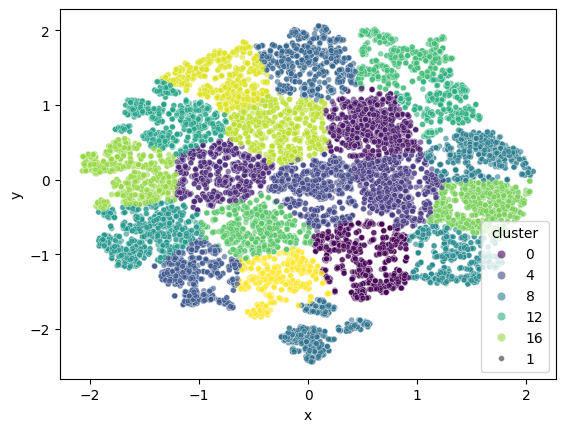

In [70]:
kmeans = KMeans(n_clusters=best_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(df[['x', 'y']])

#plot the cluster
sns.scatterplot(data=df, x='x', y='y', hue='cluster', palette='viridis', alpha=0.6, size=1)

In [72]:
from bertopic import BERTopic

cluster_0 = df[df['cluster'] == 0]

topic_model = BERTopic()
topics, probs = topic_model.fit_transform(cluster_0['text'])

topic_info = topic_model.get_topic_info()
print(topic_info.head())

   Topic  Count                              Name  \
0     -1    191   -1_columns_using_concrete_steel   
1      0    105  0_stability_soil_undrained_slope   
2      1     56            1_reactor_flow_bed_gas   
3      2     49      2_rocks_quartz_triassic_zone   
4      3     46  3_elastic_surface_substrate_beam   

                                      Representation  \
0  [columns, using, concrete, steel, results, str...   
1  [stability, soil, undrained, slope, anisotropi...   
2  [reactor, flow, bed, gas, velocity, liquid, tr...   
3  [rocks, quartz, triassic, zone, indochina, tha...   
4  [elastic, surface, substrate, beam, material, ...   

                                 Representative_Docs  
0  [investigative study prediction compressive st...  
1  [design equation stability circular tunnel ani...  
2  [comparative study local gas liquid hydrodynam...  
3  [revisiting tectonic evolution triassic palaeo...  
4  [nonlinear analysis bending buckling post buck...  


In [ ]:
import ollama

def get_cluster_label_local(titles_list):
    # Join titles into a clean list
    formatted_list = "\n".join([f"- {t}" for t in titles_list])
    
    prompt = f"""
    Analyze the following list of document titles and generate a concise, 
    3-5 word category label that best describes them.
    
    Return ONLY the label. No explanations.
    
    Titles:
    {formatted_list}
    """
    
    try:
        response = ollama.chat(model='llama3.2:3b', messages=[
            {
                'role': 'user',
                'content': prompt,
            },
        ])
        return response['message']['content'].strip()
    except Exception as e:
        return f"Error: {e}"

In [ ]:
cluster_0 = df[df['cluster'] == 0]
topic = get_cluster_label_local(cluster_0['title'].sample(20).tolist())
topic